<a href="https://colab.research.google.com/github/YinmiAlas/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!

In [0]:
true_positive_rate = 1
false_positive_rate = 0.08
prob_drunk_prior = 0.001
non_user_prior = 0.999

In [76]:
#single run Bayesian Theorem
true_positive_rate * prob_drunk_prior / false_positive_rate

0.0125

In [91]:
#Bayes Theorem to drug tests repeated
#What is the probability that a person is drunk after one positive breathalyzer test?
test = (true_positive_rate * prob_drunk_prior) / ((true_positive_rate * prob_drunk_prior) + (false_positive_rate * non_user_prior))
print('The Probability is :', test)

The Probability is : 0.012357884330202669


In [92]:
#What is the probability that a person is drunk after two positive breathalyzer tests?
test2 = (true_positive_rate * test) / ((true_positive_rate * test) + (false_positive_rate * non_user_prior))
print('The Probability is :', test2)

The Probability is : 0.13392032576279944


In [0]:
#How many positive breathalyzer tests are needed in order to have a probability
# that's greater than 95% that a person is drunk beyond the legal limit?
true_positive_rate = 1
false_positive_rate = 0.08
prob_drunk_prior = 0.001
non_user_prior = 0.999
num_ite = 10
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate, num_ite):
  prob = []
  prob2 = (true_positive_rate * prob_drunk_prior) / ((true_positive_rate * prob_drunk_prior) + (false_positive_rate * non_user_prior))
  prob3 = (true_positive_rate * prob2) / ((true_positive_rate * prob2) + (false_positive_rate * non_user_prior))
  prob4 = (true_positive_rate * prob3) / ((true_positive_rate * prob3) + (false_positive_rate * non_user_prior))
  prob5 = (true_positive_rate * prob4) / ((true_positive_rate * prob4) + (false_positive_rate * non_user_prior))
  prob6 = (true_positive_rate * prob5) / ((true_positive_rate * prob5) + (false_positive_rate * non_user_prior))
  prob7 = (true_positive_rate * prob6) / ((true_positive_rate * prob6) + (false_positive_rate * non_user_prior))
  prob8 = (true_positive_rate * prob7) / ((true_positive_rate * prob7) + (false_positive_rate * non_user_prior))
  prob.append(prob8)
  return prob

In [122]:
#the max can go is 92% because the false_positive_rate = 0.08
# meaning thats the max that a person can have in the blood of alcohol
prob_drunk_given_positive(0.001, 0.08, 1, 10)

[0.9200623900176687]

In [123]:
#but if we change it to false_positive_rate = 0.04
#give me a 96% positive 
# I need 8 Positive Tests to have a Probability 
#Greater than 95% 
prob_drunk_given_positive(0.001, 0.04, 1, 10)

[0.9600398502025782]

In [27]:
#The results of a Bayesian approach to a traditional/frequentist approach
#Explore scipy.stats.bayes_mvs
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uplouded = files.upload()

Saving house-votes-84.data to house-votes-84.data


In [6]:
column = ['team','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
house_votes = pd.read_csv('house-votes-84.data', header=None, names=column, na_values='?')
house_votes.head()

,team,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [7]:
house_votes.dropna(inplace=True)
house_votes.head()

,team,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
8,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
19,democrat,y,y,y,n,n,n,y,y,y,n,y,n,n,n,y,y
23,democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,y,y
25,democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y


In [8]:
#replacing values to integers
house_votes = house_votes.replace({'y':1, 'n':0})
house_votes.head()

,team,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,democrat,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,democrat,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


In [10]:
republican = house_votes[house_votes['team']=='republican']
republican.head(1)

,team,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
8,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1


In [12]:
democrat = house_votes[house_votes['team']=='democrat']
democrat.head(1)

,team,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1


In [15]:
democrat_values =  democrat['water-project']
democrat_values.head()

5     1
19    1
23    1
25    0
26    0
Name: water-project, dtype: int64

In [24]:
def confidence_interval (democrat_values, confidence=0.99):
  #demo_inter = np.array(demo_inter)
  mean = np.mean(democrat_values)
  n = len(democrat_values)
  stderror = np.std(democrat_values, ddof=1)/np.sqrt(n)
  #margin error
  interval = stderror * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

visuali_values = confidence_interval(democrat_values)
visuali_values

(0.45161290322580644, 0.33421049530946306, 0.5690153111421499)

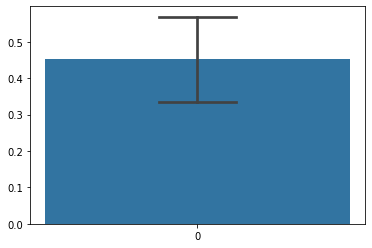

In [41]:
#visualization
#The top black line is 0.56 mean + interval
#The top barplot is the mean 0.45
#The bottom black line is 0.33  mean - interval
visualization = sns.barplot(data=visuali_values, capsize=.2)

In [34]:
#Explore scipy.stats.bayes_mvs
#I got the same values like confidence interval

mean_confidence_interval, _, _ = stats.bayes_mvs(democrat_values, alpha=0.99)
mean = mean_confidence_interval
mean

Mean(statistic=0.45161290322580644, minmax=(0.3342104953094631, 0.5690153111421498))

##summarize the difference between Bayesian and Frequentist statistics

In [0]:
'''I think the different between both is the code because 
i had the same result using differents formulas and i see Bayesian 
formula is way easier to take Confidence Interval plus the Mean
 '''

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!